Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.

SPDX-License-Identifier: Apache-2.0


# We use the notebook to illustrate OAK on the AutoMPG regression task. 

## imports and set file path

In [1]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import argparse
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from oak.model_utils import oak_model, save_model
from oak.utils import get_model_sufficient_statistics, get_prediction_component
from scipy import io
from sklearn.model_selection import KFold
from pathlib import Path

matplotlib.rcParams.update({"font.size": 25})

# +
# data from repo: https://github.com/duvenaud/additive-gps/blob/master/data/regression/
# this script is for experiments in Sec 5.1 for regression problems in the paper
data_path_prefix = os.path.join(
    Path(os.getcwd()).parent.parent.absolute(), f"data/"
)

np.set_printoptions(formatter={"float": lambda x: "{0:0.5f}".format(x)})

dataset_name, k = "autoMPG", 5
filename = data_path_prefix + "autompg.mat"
covariate_names = [
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "year",
    "origin",
]
# save results to outputs folder
if not os.path.exists(f"./outputs/{dataset_name}/"):
    os.mkdir(output_prefix)

np.random.seed(4)
tf.random.set_seed(4)

print(f"dataset {dataset_name}\n")



dataset autoMPG



# Load Data

In [2]:
d = io.loadmat(filename)
if dataset_name == "autoMPG":
    # for autoMPG dataset, the first column is the response y
    X, y = d["X"][:, 1:], d["X"][:, :1]
else:
    X, y = d["X"], d["y"]

idx = np.random.permutation(range(X.shape[0]))

X = X[idx, :]
y = y[idx]
kf = KFold(n_splits=k)

# take one fold for example 
fold = 0
for train_index, test_index in kf.split(X):
    if fold == 0:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    fold += 1
  


# Fit Model
We fit an OAK model with 200 inducing points by default

In [3]:
oak = oak_model(max_interaction_depth=X.shape[1])
oak.fit(X_train, y_train)

# test performance
x_max, x_min = X_train.max(0), X_train.min(0)
y_pred = oak.predict(np.clip(X_test, x_min, x_max))
rss = ((y_pred - y_test[:, 0]) ** 2).mean()
tss = (
    (y_test[:, 0] - y_test[:, 0].mean() * np.ones(y_test[:, 0].shape)) ** 2
).mean()
r2 = 1 - rss / tss
rmse = np.sqrt(rss)

# calculate sobol for each term in the decomposition
oak.get_sobol()
tuple_of_indices, normalised_sobols = (
    oak.tuple_of_indices,
    oak.normalised_sobols,
)

# Get predictions for each term (kernel) in prediction_list
x_max, x_min = X_train.max(0), X_train.min(0)
XT = oak._transform_x(np.clip(X_test, x_min, x_max))
oak.alpha = get_model_sufficient_statistics(oak.m, get_L=False)
# get the predicted y for all the kernel components
prediction_list = get_prediction_component(
    oak.m,
    oak.alpha,
    XT,
)
# predicted y for the constant kernel
constant_term = oak.alpha.numpy().sum() * oak.m.kernel.variances[0].numpy()
print(f"constant_term = {constant_term}")
y_pred_component = np.ones(y_test.shape[0]) * constant_term

# get prediction performance and cumulative Sobol as we add terms one by one
# ranked by their Sobol (most important kernel first)
cumulative_sobol, rmse_component = [], []
order = np.argsort(normalised_sobols)[::-1]
for n in order:
    # add predictions of the terms one by one ranked by their Sobol index
    y_pred_component += prediction_list[n].numpy()
    y_pred_component_transformed = oak.scaler_y.inverse_transform(
        y_pred_component.reshape(-1, 1)
    )
    error_component = np.sqrt(
        ((y_pred_component_transformed - y_test) ** 2).mean()
    )
    rmse_component.append(error_component)
    cumulative_sobol.append(normalised_sobols[n])
cumulative_sobol = np.cumsum(cumulative_sobol)

# sanity check that predictions by summing over the components is equal
# to the prediction of the OAK model
np.testing.assert_allclose(y_pred_component_transformed[:, 0], y_pred)


indices of binary feature  []
indices of continuous feature  [0, 1, 2, 3, 4, 5, 6]
indices of categorical feature  []


2022-03-08 17:03:20.164274: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-08 17:03:20.194154: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc8ace35650 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-08 17:03:20.194173: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-03-08 17:03:20.211287: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


[None, None, None, None, None, None, None]
Using sparsity prior


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.9006
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.35845
GPR.kernel.kernels[2].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,3.09235
GPR.kernel.kernels[3].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,2.86591
GPR.kernel.kernels[4].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,3.16615
GPR.kernel.kernels[5].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.492342
GPR.kernel.kernels[6].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.400154
GPR.kernel.variances[0],Parameter,Softplus,Gamma,True,(),float64,1.39689e-20
GPR.kernel.variances[1],Parameter,Softplus,Gamma,True,(),float64,0.260294
GPR.kernel.variances[2],Parameter,Softplus,Gamma,True,(),float64,0.0180703


Training took 15.5 seconds.
constant_term = -2.031302030800762e-20


In [4]:
# negative log likelihood
nll = (
    -oak.m.predict_log_density(
        (
            oak._transform_x(np.clip(X_test, x_min, x_max)),
            oak.scaler_y.transform(y_test),
        )
    )
    .numpy()
    .mean()
)

print(f"oak test rmse = {rmse}, r2 = {r2}\n")
print(f"RBF test nll = {np.round(nll, 4)}\n")

oak test rmse = 2.9626436399561595, r2 = 0.8654957885839086

RBF test nll = 0.4482



# Plotting

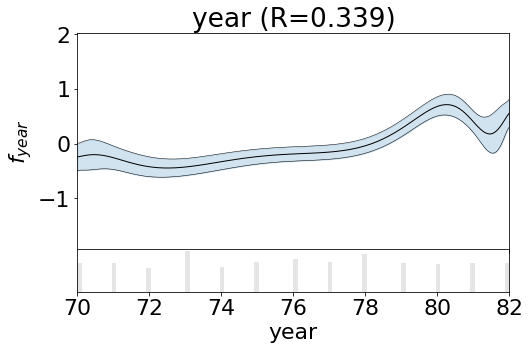

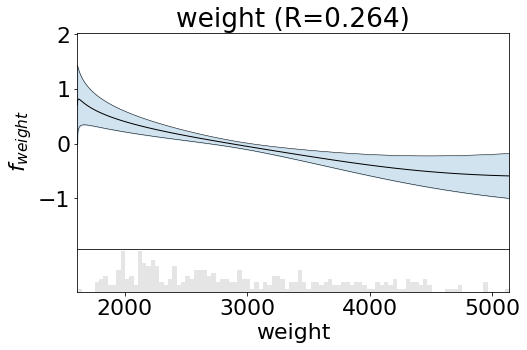

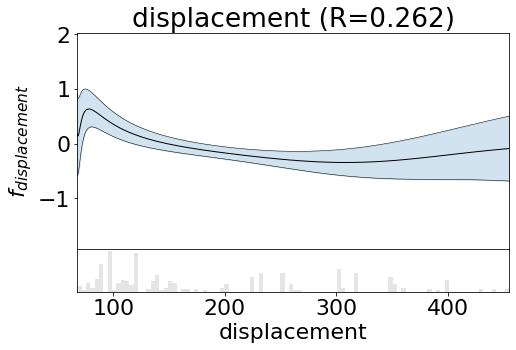

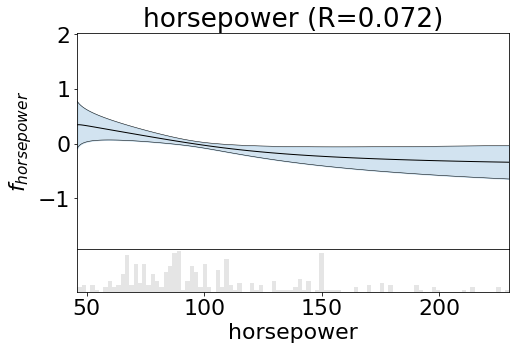

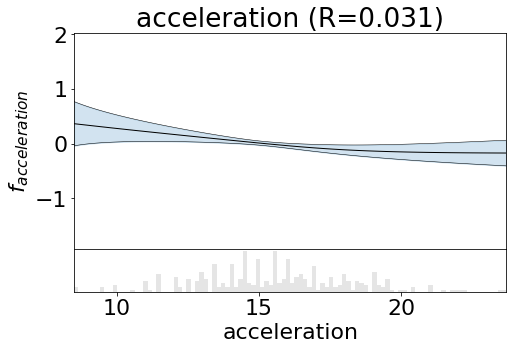

In [5]:
# plot decomposition of the functions, ranked by their (normalised) Sobol index, 
# which are in the bracket in ther plot title
oak.plot(
    top_n=5,
    semilogy=False,
    X_columns=covariate_names,
)

<Figure size 576x288 with 0 Axes>

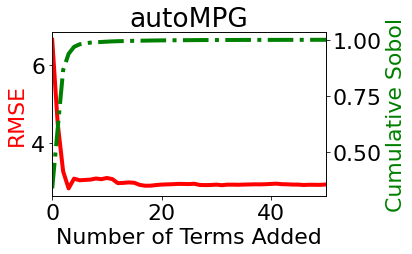

In [6]:
# generate plots in Fig. 5 (\ref{fig:sobol_plots}) of paper
plt.figure(figsize=(8, 4))
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(np.arange(len(order)), rmse_component, "r", linewidth=4)
ax2.plot(np.arange(len(order)), cumulative_sobol, "-.g", linewidth=4)

ax1.set_xlabel("Number of Terms Added")
ax1.set_ylabel("RMSE", color="r")
ax2.set_ylabel("Cumulative Sobol", color="g")

plt.title(dataset_name)
plt.xlim([0,50])
plt.tight_layout()

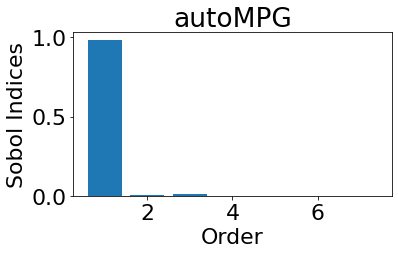

In [7]:
# aggregate sobol per order of interactions
sobol_order = np.zeros(len(tuple_of_indices[-1]))
for i in range(len(tuple_of_indices)):
    sobol_order[len(tuple_of_indices[i]) - 1] += normalised_sobols[i]


# generate plot similar to Figure 4 (\ref{fig:sobol}) in the paper for one fold. 
# Figure 4 (\ref{fig:sobol}) in the paper takes the mean and adds standard deviation for 5 folds. 
fig, ax = plt.subplots()
for j in range(len(sobol_order)):
    plt.bar(j+1, np.array([sobol_order[j] ]).mean(),\
           yerr = np.array([sobol_order[j] ]).std(),\
           color = 'C0', ecolor = 'k')

plt.xlabel('Order')
plt.ylabel('Sobol Indices')
plt.title(dataset_name)
plt.tight_layout()

